
# 🧠 Linear Perceptron with Mini-Batch Gradient Descent

This notebook demonstrates a **manual implementation of the Perceptron algorithm** using only `NumPy`.  
It showcases the use of **mini-batch gradient descent**, a custom **cost function**, and **decision boundary visualization**.

---

### 🔍 Overview
- Implementation of a **linear Perceptron** from scratch  
- Use of **mini-batch gradient descent** for optimization  
- Definition of a separate **cost function** \( J(w) \) and gradient computation  
- Visualization of the **decision boundary evolution** throughout training  

**Dataset:** [Breast Cancer Wisconsin (Diagnostic)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)


## 1️⃣ Import Dependencies

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)



## 2️⃣ Dataset Preparation

To visualize the decision boundary, only **two features** from the dataset are used.  
Labels are mapped to \( \{-1, +1\} \) to align with the classical Perceptron formulation.


In [2]:

data = load_breast_cancer()
X_full, y01 = data.data, data.target

# Select two features for 2D visualization
feat_idx = (0, 1)  # mean radius, mean texture
X2 = X_full[:, feat_idx]

# Convert labels from {0, 1} to {-1, +1}
y = np.where(y01 == 1, 1, -1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Add bias term to each sample
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

X_train_b = add_bias(X_train)
X_test_b  = add_bias(X_test)



## 3️⃣ Perceptron Cost Function and Gradient

The **Perceptron cost function** penalizes misclassified samples only:

\[
J(w) = - \sum_{i \in M} y_i (w^T x_i)
\]

where \( M = \{ i : y_i (w^T x_i) \leq 0 \} \).  

The corresponding **gradient** is given by:

\[
\nabla J(w) = - \sum_{i \in M} y_i x_i
\]


In [3]:

def J_perceptron(w, Xb, y):
    margins = y * (Xb @ w)
    mis_idx = margins <= 0
    if not np.any(mis_idx):
        return 0.0
    return -np.sum(y[mis_idx] * (Xb[mis_idx] @ w))

def grad_perceptron(w, Xb, y):
    margins = y * (Xb @ w)
    mis_idx = margins <= 0
    if not np.any(mis_idx):
        return np.zeros_like(w)
    return -np.sum((y[mis_idx, None] * Xb[mis_idx]), axis=0)



## 4️⃣ Mini-Batch Gradient Descent Implementation

In each epoch, data is shuffled and divided into small mini-batches.  
Weights are updated iteratively based on the Perceptron gradient for misclassified samples.


In [4]:

def minibatch_gradient_descent(
    Xb, y, lr=0.1, batch_size=32, epochs=50, shuffle=True, record_each_epoch=True
):
    n, d = Xb.shape
    w = np.zeros(d, dtype=float)

    W_history = [w.copy()]
    best_w = w.copy()
    best_J = J_perceptron(w, Xb, y)

    for ep in range(epochs):
        if shuffle:
            idx = np.random.permutation(n)
            Xb, y = Xb[idx], y[idx]

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            Xb_batch = Xb[start:end]
            y_batch  = y[start:end]

            g = grad_perceptron(w, Xb_batch, y_batch)
            w = w - lr * g

            J_curr = J_perceptron(w, Xb, y)
            if J_curr < best_J:
                best_J = J_curr
                best_w = w.copy()

        if record_each_epoch:
            W_history.append(w.copy())

    return w, best_w, np.array(W_history)



## 5️⃣ Training the Model


In [5]:

w_last, w_best, W_hist = minibatch_gradient_descent(
    X_train_b, y_train, lr=0.05, batch_size=32, epochs=80, shuffle=True
)

print("w_last:", w_last)
print("w_best:", w_best)
print("J(w_last) =", J_perceptron(w_last, X_train_b, y_train))
print("J(w_best) =", J_perceptron(w_best, X_train_b, y_train))


w_last: [-4.19020609e-01 -8.97636053e-02 -2.22044605e-16]
w_best: [0. 0. 0.]
J(w_last) = 6.233005744635074
J(w_best) = -0.0



## 6️⃣ Evaluation on Train/Test Sets


In [6]:

def predict_sign(Xb, w):
    return np.where(Xb @ w >= 0, 1, -1)

y_hat_train = predict_sign(X_train_b, w_best)
y_hat_test  = predict_sign(X_test_b,  w_best)

acc_train = (y_hat_train == y_train).mean()
acc_test  = (y_hat_test  == y_test ).mean()

print(f"Train Accuracy: {acc_train:.3f}")
print(f"Test  Accuracy: {acc_test:.3f}")


Train Accuracy: 0.626
Test  Accuracy: 0.632



## 7️⃣ Decision Boundary Visualization

The following plot illustrates the **evolution of the decision boundary** over training epochs.  
Earlier boundaries are shown in lighter shades, while the final (best) boundary is bold and darker.


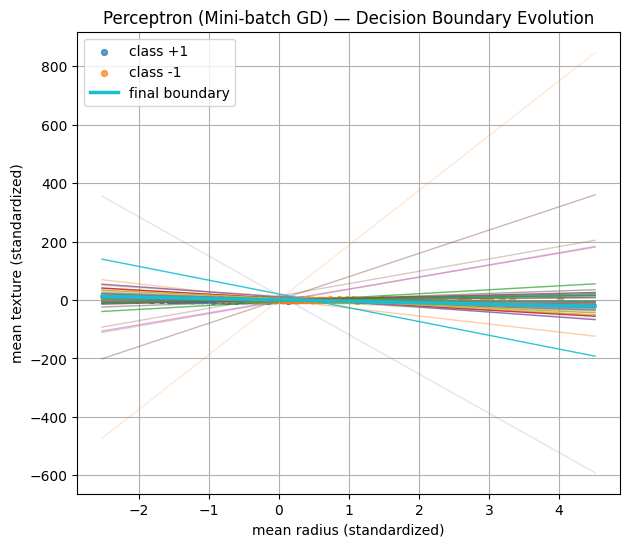

In [7]:

def plot_decision_lines(W_list, X, y, title):
    x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    xs = np.linspace(x1_min, x1_max, 200)

    L = len(W_list)
    alphas = np.linspace(0.15, 1.0, L)

    plt.figure(figsize=(7,6))
    plt.scatter(X[y==1,0],  X[y==1,1],  s=18, label="class +1", alpha=0.7)
    plt.scatter(X[y==-1,0], X[y==-1,1], s=18, label="class -1", alpha=0.7)

    for i, w in enumerate(W_list):
        w1, w2, b = w
        if abs(w2) < 1e-8:
            continue
        ys = -(w1/w2) * xs - (b/w2)
        lw = 1.0 if i < L-1 else 2.5
        plt.plot(xs, ys, alpha=alphas[i], linewidth=lw,
                 label="final boundary" if i==L-1 else None)

    plt.title(title)
    plt.xlabel(data.feature_names[feat_idx[0]] + " (standardized)")
    plt.ylabel(data.feature_names[feat_idx[1]] + " (standardized)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_lines(W_hist, X_train, y_train, "Perceptron (Mini-batch GD) — Decision Boundary Evolution")



## ✅ Conclusion

- A **linear Perceptron** was implemented using **mini-batch gradient descent**.  
- The model converged to a stable linear decision boundary capable of distinguishing benign vs. malignant samples.  
- This minimalistic implementation demonstrates the relationship between **linear classifiers** and **iterative optimization** techniques.

---

**Author:** Your Name  
**Date:** 2025  
**License:** MIT
